## Step 1

#### Target

1. Settle on an Architecture
2. Visualize Data
3. Define Data Loaders
4. Define data transformations, Image Normalization
5. Designing a capable model architecture

#### Result

1. Parameters: **433,866**
2. Best Training Accuracy: **99.80**
3. Best Test Accuracy: **99.13**

#### Analysis

1. Model trains very good
2. Capable model as both train and test accuracies above 99
3. There is Over-fitting

In [1]:
# import necessary libraries

from __future__ import print_function

import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from tqdm import tqdm
from torchsummary import summary
from torchvision import datasets, transforms

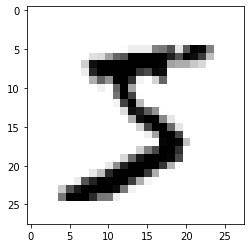

In [2]:
# Download and visualize data

sample_data = datasets.MNIST('./data', train=True, download=True).data

# Setting the values in the data to be within the range [0, 1]
sample_data = sample_data.numpy() / 255

plt.imshow(sample_data[0], cmap='gray_r')

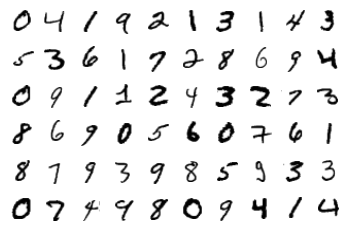

In [3]:
figure = plt.figure()
num_of_images = 60
for index in range(1, num_of_images + 1):
    plt.subplot(6, 10, index)
    plt.axis('off')
    plt.imshow(sample_data[index], cmap='gray_r')

In [4]:
# Calculating Mean and STD for the data

mean = np.mean(sample_data)
std = np.std(sample_data)

print('mean : ', mean)
print('std : ', std)

mean :  0.1306604762738429
std :  0.3081078038564622


### Data Transformation

In [5]:
# Train data transformations
train_transforms = transforms.Compose([
    # convert the data to torch.FloatTensor with values within the range [0.0 ,1.0]
    transforms.ToTensor(),

    # normalize the data with mean and standard deviation
    transforms.Normalize((mean,), (std,))
])

# Test data transformations
test_transforms = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((mean,), (std,))
])

### Data Loader

In [6]:
train = datasets.MNIST('./data', train=True, download=True, transform=train_transforms)
test = datasets.MNIST('./data', train=False, download=True, transform=test_transforms)

In [7]:
SEED = 1

cuda = torch.cuda.is_available()
print('CUDA Available?', cuda)

# For reproducibility of results
torch.manual_seed(SEED)
if cuda:
    torch.cuda.manual_seed(SEED)

# dataloader arguments
dataloader_args = dict(shuffle=True, batch_size=64, num_workers=4, pin_memory=True) if cuda else dict(shuffle=True, batch_size=64)

# train dataloader
train_loader = torch.utils.data.DataLoader(train, **dataloader_args)

# test dataloader
test_loader = torch.utils.data.DataLoader(test, **dataloader_args)

CUDA Available? True


### Designing the Model Architecture

In [8]:
class Net(nn.Module):
    def __init__(self):
        """ This function instantiates all the model layers """
        super(Net, self).__init__()

        self.convblock1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3),
            nn.ReLU()
        )  # Input: 28x28x1 | Output: 26x26x16 | RF: 3x3

        self.convblock2 = nn.Sequential(
            nn.Conv2d(in_channels=16, out_channels=32, kernel_size=3),
            nn.ReLU()
        )  # Input: 26x26x16 | Output: 24x24x16 | RF: 5x5

        self.convblock3 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU()
        )  # Input: 24x24x16 | Output: 22x22x16 | RF: 7x7

        self.pool = nn.MaxPool2d(2, 2)  # Input: 22x22x16 | Output: 11x11x16 | RF: 8x8

        self.convblock4 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
            nn.ReLU()
        )  # Input: 11x11x16 | Output: 9x9x16 | RF: 12x12

        self.convblock5 = nn.Sequential(
            nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3),
            nn.ReLU()
        )  # Input: 9x9x16 | Output: 7x7x16 | RF: 16x16

        self.convblock6 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3),
            nn.ReLU()
        )  # Input: 7x7x16 | Output: 5x5x16 | RF: 20x20

        self.convblock7 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=256, kernel_size=3),
            nn.ReLU()
        )  # Input: 5x5x16 | Output: 3x3x16 | RF: 24x24

        self.convblock8 = nn.Sequential(
            nn.Conv2d(in_channels=256, out_channels=10, kernel_size=3)
        )  # Input: 3x3x16 | Output: 1x1x10 | RF: 28x28
    
    def forward(self, x):
        """ This function defines the network structure """
        x = self.convblock1(x)
        x = self.convblock2(x)
        x = self.convblock3(x)
        x = self.pool(x)
        x = self.convblock4(x)
        x = self.convblock5(x)
        x = self.convblock6(x)
        x = self.convblock7(x)
        x = self.convblock8(x)
        x = x.view(-1, 10)
        return F.log_softmax(x, dim=-1)

In [9]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print(device)
model = Net().to(device)
summary(model, input_size=(1, 28, 28))

cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 26, 26]             160
              ReLU-2           [-1, 16, 26, 26]               0
            Conv2d-3           [-1, 32, 24, 24]           4,640
              ReLU-4           [-1, 32, 24, 24]               0
            Conv2d-5           [-1, 32, 22, 22]           9,248
              ReLU-6           [-1, 32, 22, 22]               0
         MaxPool2d-7           [-1, 32, 11, 11]               0
            Conv2d-8             [-1, 32, 9, 9]           9,248
              ReLU-9             [-1, 32, 9, 9]               0
           Conv2d-10             [-1, 64, 7, 7]          18,496
             ReLU-11             [-1, 64, 7, 7]               0
           Conv2d-12            [-1, 128, 5, 5]          73,856
             ReLU-13            [-1, 128, 5, 5]               0
           Conv2d-14            [-

### Train and Test functions

In [10]:
train_losses, train_accuracies = [], []
test_losses, test_accuracies = [], []

def train(model, device, train_loader, optimizer, epoch):
    model.train()
    pbar = tqdm(train_loader)
    correct = 0
    processed = 0
    for batch_idx, (data, target) in enumerate(pbar):
        # Get samples
        data, target = data.to(device), target.to(device)

        # Set gradients to zero before starting backpropagation
        optimizer.zero_grad()

        # Predict output
        y_pred = model(data)

        # Calculate loss
        loss = F.nll_loss(y_pred, target)
        train_losses.append(loss)

        # Perform backpropagation
        loss.backward()
        optimizer.step()

        # Update Progress Bar
        pred = y_pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        processed += len(data)
        train_accuracies.append(100 * correct / processed)
        pbar.set_description(desc=f'Loss={loss.item():0.2f} Batch_ID={batch_idx} Accuracy={train_accuracies[-1]:.2f}')


def test(model, device, test_loader):
    model.eval()
    test_loss = 0
    correct = 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(device), target.to(device)
            output = model(data)
            test_loss += F.nll_loss(output, target, reduction='sum').item()  # sum up batch loss
            pred = output.argmax(dim=1, keepdim=True)  # get the index of the max log-probability
            correct += pred.eq(target.view_as(pred)).sum().item()

    test_loss /= len(test_loader.dataset)
    test_losses.append(test_loss)
    test_accuracies.append(100. * correct / len(test_loader.dataset))

    print(f'\nTest set: Average loss: {test_loss:.4f}, Accuracy: {correct}/{len(test_loader.dataset)} ({test_accuracies[-1]:.2f}%)\n')

In [11]:
model = Net().to(device)
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9)
epochs = 15

for epoch in range(1, epochs + 1):
    print(f'Epoch {epoch}:')
    train(model, device, train_loader, optimizer, epoch)
    test(model, device, test_loader)

  0%|          | 0/938 [00:00<?, ?it/s]

Epoch 1:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0723, Accuracy: 9762/10000 (97.62%)

Epoch 2:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0637, Accuracy: 9791/10000 (97.91%)

Epoch 3:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0396, Accuracy: 9865/10000 (98.65%)

Epoch 4:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9906/10000 (99.06%)

Epoch 5:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0341, Accuracy: 9899/10000 (98.99%)

Epoch 6:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0465, Accuracy: 9872/10000 (98.72%)

Epoch 7:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0424, Accuracy: 9877/10000 (98.77%)

Epoch 8:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0419, Accuracy: 9883/10000 (98.83%)

Epoch 9:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0407, Accuracy: 9891/10000 (98.91%)

Epoch 10:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0352, Accuracy: 9908/10000 (99.08%)

Epoch 11:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0332, Accuracy: 9904/10000 (99.04%)

Epoch 12:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0378, Accuracy: 9908/10000 (99.08%)

Epoch 13:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0400, Accuracy: 9904/10000 (99.04%)

Epoch 14:


  0%|          | 0/938 [00:00<?, ?it/s]


Test set: Average loss: 0.0344, Accuracy: 9906/10000 (99.06%)

Epoch 15:


Loss=0.00 Batch_ID=937 Accuracy=99.80: 100%|██████████| 938/938 [00:04<00:00, 189.55it/s]



Test set: Average loss: 0.0381, Accuracy: 9913/10000 (99.13%)



### Plot Loss and Accuracy

Text(0.5, 1.0, 'Test Accuracy')

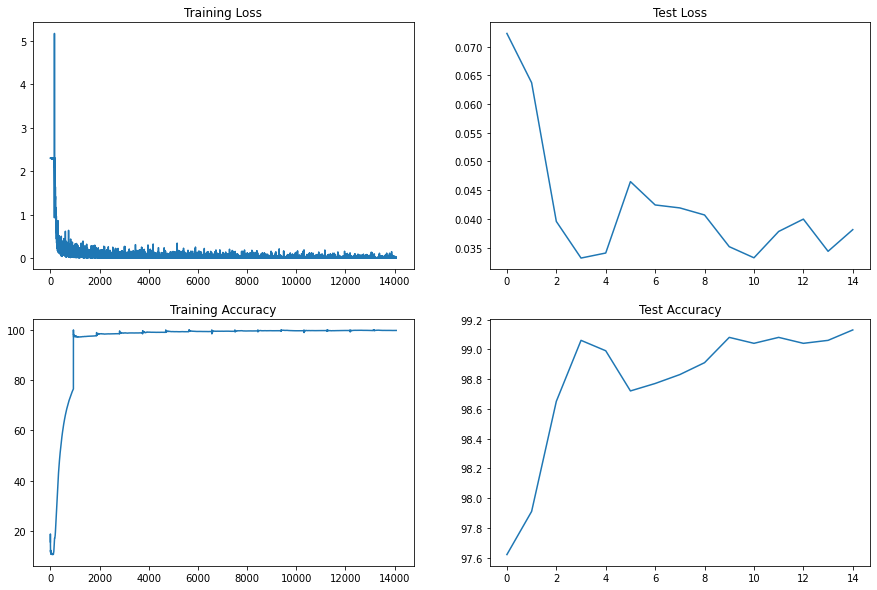

In [13]:
fig, axs = plt.subplots(2,2,figsize=(15,10))
axs[0, 0].plot(train_losses)
axs[0, 0].set_title("Training Loss")
axs[1, 0].plot(train_accuracies)
axs[1, 0].set_title("Training Accuracy")
axs[0, 1].plot(test_losses)
axs[0, 1].set_title("Test Loss")
axs[1, 1].plot(test_accuracies)
axs[1, 1].set_title("Test Accuracy")